# Understanding Fraud Detection
### Anosh.S

Using python this python notebook will automatically identify fraudulent credit card transactions utilising processes in machine learning.

As economic crime grows the concern for fraudulent activity has risen. As a result, the rise in deep learning, artificial intelligence and machine learning methods has facilitated many means for automating such a process. Through a systematic identification of outliers, developing this pythonic approach, potential anomalies can be understood and dealt with accordingly.

Below the process is as follows:

## Initial Data Analysis

First uploading the data, using pandas we can gather a first glance of the data for which we want to detect fraudulent activity from. For this we will use the creditcard.csv data from Kaggle: https://www.kaggle.com/c/ieee-fraud-detection/data

In [1]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ieee-fraud-detection

Saving kaggle.json to kaggle (1).json
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd
import numpy as np

id_raw_df = pd.read_csv('train_identity.csv.zip')
id_trans_df = pd.read_csv('train_transaction.csv.zip')

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Just to understand the dimensions of our dataframe
id_raw_df.shape

(144233, 41)

In [4]:
id_trans_df.shape

(590540, 394)

In [0]:
train_full_df = pd.merge(id_trans_df, id_raw_df, on='TransactionID', how='left')

In [6]:
train_full_df.shape

(590540, 434)

In [7]:
# Percentage of Fraudulent instances present in the collected data
len(train_full_df[train_full_df['isFraud']==1])/len(train_full_df)*100

3.4990009144173126

Before we continue let's visualise the number of fradulent and non-fradulent cases from the dataset, whilst optimising memory usage:

In [0]:
import gc,os,sys
import re

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

pd.options.display.float_format = '{:,.3f}'.format

In [0]:
# Memory saving function https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
  ''' iterate through all the columns of a dataframe and modify the data type to reduce memory usage
  '''
  start_mem = df.memory_usage().sum()/1024**2

  for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)  
      else:
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
          df[col] = df[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)
    #else:
      #df[col] = df[col].astype('category')

  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [10]:
# Loading data
%%time
train_id = pd.read_csv('train_identity.csv.zip')
train_trn = pd. read_csv('train_transaction.csv.zip')
test_id = pd.read_csv('test_identity.csv.zip')
test_trn = pd.read_csv('test_transaction.csv.zip')

CPU times: user 1min 11s, sys: 2.54 s, total: 1min 13s
Wall time: 1min 13s


In [11]:
# Loading memory efficient data
train_id = reduce_mem_usage(train_id)
train_trn = reduce_mem_usage(train_trn)
test_id = reduce_mem_usage(test_id)
test_trn = reduce_mem_usage(test_trn)

Memory usage of dataframe is 45.12 MB --> 25.86 MB (Decreased by 42.7%)
Memory usage of dataframe is 1775.15 MB --> 542.35 MB (Decreased by 69.4%)
Memory usage of dataframe is 44.39 MB --> 25.44 MB (Decreased by 42.7%)
Memory usage of dataframe is 1519.24 MB --> 472.59 MB (Decreased by 68.9%)


,0,1
isFraud,0.965,0.035


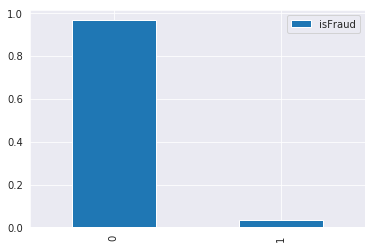

In [12]:
# Target variable visual comparison
fc = train_trn['isFraud'].value_counts(normalize = True).to_frame()
fc.plot.bar()
fc.T

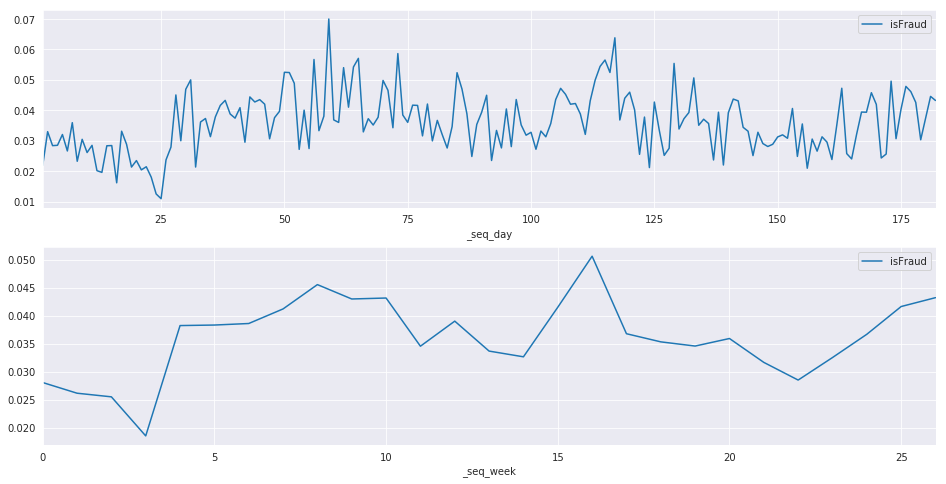

In [13]:
#Fraud transaction rate by day
fig,ax = plt.subplots(2, 1, figsize = (16,8))
train_trn['_seq_day'] = train_trn['TransactionDT'] // (24*60*60)
train_trn['_seq_week'] = train_trn['_seq_day'] // 7
train_trn.groupby('_seq_day')['isFraud'].mean().to_frame().plot.line(ax = ax[0])
train_trn.groupby('_seq_week')['isFraud'].mean().to_frame().plot.line(ax = ax[1])

In [14]:
'''
train_trn['P_emaildomain_prefix'] = train_trn['P_emaildomain'].apply(lambda x: x.split('.')[0])
ct = pd.crosstab(train_trn['P_emaildomain_prefix'], train_trn['ProductCD'])
ct = ct.sort_values(by='W')[-15:]
ct.plot.barh(stacked = True, figsize=(12, 4))
'''

AttributeError: ignored

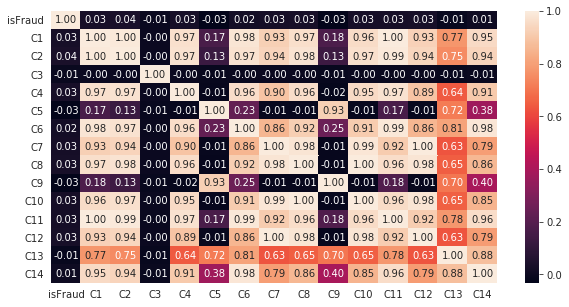

In [16]:
# Correlation Heatmap of features C1 to C14

ccols = ['C%d' % number for number in range(1,15)]

plt.figure(figsize = (10,5))

corr = train_trn[['isFraud'] + ccols].corr()
sns.heatmap(corr, annot = True, fmt = '.2f')

## Visualising NaN Values

By inspection we can identify which features would be healthy and thus most appropriate to be considered in the generation of our fraud prediction model. 

In [0]:
# Visualising NaN values
plt.figure(figsize = (90,40))
sns.barplot(y = train_full_df.isnull().sum().sort_values(ascending=False)/len(train_full_df),
            x = train_full_df.isnull().sum().sort_values(ascending=False).index,
            palette = 'Reds_d')
plt.title('Percent of Missing Values', size = 50)
plt.xticks(rotation = 90)

## Challenges with NaN values
The dataset containing multiple NaN values in a number of the features this prevents it from achieving optimal effectiveness. To overcome this we can predict their values from known features through multi-output regression - a multiclass algorithm - and random forest regression.

A simple solution is to replace the NaN values with medians, however this limits the algorithm's accuracy unlike using the prediction method above.

However to quickly produce this algorithm for now we will apply a limiting condition that will select features based on a threshold percentage of NaN values contained within each feature.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Dataframe that will the number of NaN values for a particular column and the percentage of NaN values per column
columns_def = pd.DataFrame({"na_count": train_full_df.isnull().sum().sort_values(ascending = False)})

In [0]:
columns_def["per"] = columns_def["na_count"]/len(train_full_df)
columns_def

In [0]:
# Cycle through various limits for percent NaN per column

range = [0.05, 0.10, 0.15, 0.25, 0.40, 0.60, 0.75]

In [0]:
# This will output what percentage of total columns/features will be considered for each of the thresholds
for i in range:
  print(str(i) + ":", columns_def[columns_def['per']<i].shape[0]/train_full_df.shape[1])

In [0]:
#Tolerating columns with less or equal to 15% of NaN values
limit = 0.15

In [0]:
# Final selection of columns that satisfy the limiting condition
columns_final = columns_def[columns_def['per'] < limit].index

train_full_df = train_full_df[train_full_df.columns.intersection(columns_final)]

In [0]:
#Checking new dataframe
train_full_df.shape

## Resolving Categorical Variables

Qualitative measures present a new set of challenges where due to their nature being either a string or factor can require some degree of data pre-processing to optimise the machine learning algorithm. A simple solution is create dummy variables:

In [0]:
# Display all qualitative variables
train_full_df[train_full_df.select_dtypes(include = ['object']).columns]

In [0]:
card6_dummy_df = pd.get_dummies(train_full_df['card6'])

In [0]:
card6_dummy_df

In [0]:
#Adding these dummy variables to the dataset
train_full_df = pd.concat([train_full_df,card6_dummy_df], axis = 1)

In [0]:
train_full_df = train_full_df._get_numeric_data()
train_full_df = train_full_df.dropna()

# The percentage of fradulent instances after transformation of categorical variable card6
len(train_full_df[train_full_df['isFraud']==1])/len(train_full_df)*100

In [0]:
x_full_df = train_full_df.drop(['isFraud'], axis = 1)
y_full_df = train_full_df['isFraud']

In [0]:
X_train,X_test,y_train,y_test = train_test_split(x_full_df,y_full_df,test_size=0.50)

## Understanding the Data

Machine learning algorithms are only most effective when the approaches of identified fraud on a training set are tested on a test set. If we were to train the data and test it on the same dataset this would be memorisation and wouldn't optimise the algorithm for identifying from unknown datasets. Hence, a separate test dataset will be used.

## Modelling

Through a binary target variable approach, this can be best achieved through applying a logistic regression model.

In [0]:
# Installing the relevant dependencies
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [0]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)

In [0]:
# Accurcay of predictions
lr.score(X_test, y_test)

In [0]:
y_pred = lr.predict(X_test)

In [0]:
# Computing the confusion matrix
pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True)

In [0]:
# Below is basically 10/4421
recall_score(y_test, y_pred)

In [0]:
accuracy_score(y_test, y_pred)

## Conclusion

Considering the confusion matrix above, to understand how effective the algortihm was at detecting fradulent instances, it is more important to consider its recall score rather than accuracy. This is because recall score summarises the percentage of true fraudulent instances detected. Thus, despite high accuracy a low recall score implies that the model remains flawed and could be improved with greater categorical features to compare or possibly a greater NaN range.